In [108]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

import cfbd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('future.no_silent_downcasting', True)

with open("../config.json") as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)["CFBD_API_KEY"]
    )

## 1. Load the Data

In [36]:
YEARS = range(2023, 2024)
DATA_DIR = "../data"

In [37]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower())
    return cols_new

In [38]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, "games")
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in YEARS:
    file_path = join(games_dir, f"{year}.parquet")
    if os.path.exists(file_path):
        print(f"Reading {file_path} from cached data")
        df_tmp = pd.read_parquet(file_path)
    else:
        print(f"Fetching {year} games data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)
        df_tmp = df_tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        df_tmp['season_type'] = df_tmp['season_type'].apply(lambda x: x.value)
        df_tmp = df_tmp.assign(
            home_division=df_tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=df_tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        df_tmp = df_tmp[id_cols + home_cols + away_cols]
        df_tmp.to_parquet(file_path)
    all_dfs.append(df_tmp)
del df_tmp

df_games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_games.head()

Reading ../data/games/2023.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo
0,401525434,2023,1,regular,True,True,3504.0,87,Notre Dame,FBS Independents,fbs,42.0,1733.0,2426,Navy,American Athletic,fbs,3.0,1471.0
1,401540199,2023,1,regular,True,True,3689.0,2382,Mercer,Southern,fcs,17.0,NaN,2453,North Alabama,UAC,fcs,7.0,NaN
2,401520145,2023,1,regular,True,False,3662.0,55,Jacksonville State,Conference USA,fbs,17.0,1500.0,2638,UTEP,Conference USA,fbs,14.0,1369.0
3,401525450,2023,1,regular,True,False,3601.0,166,New Mexico State,Conference USA,fbs,30.0,1322.0,113,Massachusetts,FBS Independents,fbs,41.0,1074.0
4,401540628,2023,1,regular,True,False,4419.0,399,UAlbany,CAA,fcs,34.0,NaN,2230,Fordham,Patriot,fcs,13.0,NaN


In [39]:
# Load drives data
all_dfs = []

drives_dir = join(DATA_DIR, "drives")
if not os.path.exists(drives_dir):
    os.makedirs(drives_dir)

for year in YEARS:
    season_file_path = join(drives_dir, f"{year}.parquet")
    
    if os.path.exists(season_file_path):
        print(f"Reading {season_file_path} from cached data")
        df_season_drives = pd.read_parquet(season_file_path)
    else:
        print(f"Fetching {year} drives data from CFBD API")
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.DrivesApi(api_client)
            data = api_instance.get_drives(year=year)
        df_tmp = pd.DataFrame([val.to_dict() for val in data])
        df_tmp.columns = convert_to_snake_case(df_tmp.columns)

        df_tmp["start_time_minutes"] = df_tmp["start_time"].apply(lambda x: x["minutes"])
        df_tmp["start_time_seconds"] = df_tmp["start_time"].apply(lambda x: x["seconds"])
        df_tmp["end_time_minutes"] = df_tmp["end_time"].apply(lambda x: x["minutes"])
        df_tmp["end_time_seconds"] = df_tmp["end_time"].apply(lambda x: x["seconds"])
        df_tmp.drop(columns=["start_time","end_time"], inplace=True)

        df_season_drives = df_tmp.copy()
                
        df_season_drives.to_parquet(season_file_path)
        print(f"Saved drives data for {year} to {season_file_path}")

    all_dfs.append(df_season_drives)
    
df_drives = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
df_drives.head()

Reading ../data/drives/2023.parquet from cached data


,offense,offense_conference,defense,defense_conference,game_id,id,drive_number,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,Jacksonville State,Conference USA,UTEP,Conference USA,401520145,4015201451,1,False,1,25,75,1,33,67,5,8,PUNT,True,0,0,0,0,15,0,12,37
1,UTEP,Conference USA,Jacksonville State,Conference USA,401520145,4015201452,2,False,1,95,95,1,53,53,9,42,DOWNS,False,0,0,0,0,12,37,8,0
2,Jacksonville State,Conference USA,UTEP,Conference USA,401520145,4015201453,3,True,1,53,47,1,77,23,10,24,FG,True,0,0,3,0,8,0,4,57
3,UTEP,Conference USA,Jacksonville State,Conference USA,401520145,4015201454,4,False,1,75,75,1,58,58,5,17,PUNT,False,0,3,0,3,4,57,2,6
4,Jacksonville State,Conference USA,UTEP,Conference USA,401520145,4015201455,5,True,1,20,80,2,100,0,12,80,TD,True,3,0,10,0,2,6,13,26


In [40]:
df_drives.drive_result.value_counts().reset_index().query('drive_result.str.lower().str.contains("punt")')

,drive_result,count
0,PUNT,12917
13,PUNT TD,66
15,PUNT RETURN TD,28
24,BLOCKED PUNT,1


## 2. Join and Filter the Data

In [41]:
# Merge games and drives data

id_cols = ['game_id', 'drive_id', 'drive_number','season', 'week']
game_cols = ['id', 'season', 'week', 'season_type', 'completed',
             'home_id', 'home_team', 'home_conference', 'home_division',
             'away_id', 'away_team', 'away_conference', 'away_division']

df_joined = (
    df_games[game_cols]
    .merge(df_drives.rename(columns={'id':'drive_id'}), left_on='id', right_on='game_id')
    .drop(columns=['id'])
)
df_joined = df_joined[id_cols + [c for c in df_joined.columns if c not in id_cols]]
df_joined.head()

,game_id,drive_id,drive_number,season,week,season_type,completed,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,offense_conference,defense,defense_conference,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,start_offense_score,start_defense_score,end_offense_score,end_defense_score,start_time_minutes,start_time_seconds,end_time_minutes,end_time_seconds
0,401525434,4015254341,1,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Notre Dame,FBS Independents,Navy,American Athletic,True,1,19,81,1,100,0,13,81,TD,True,0,0,7,0,15,0,8,26
1,401525434,4015254342,2,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Navy,American Athletic,Notre Dame,FBS Independents,False,1,75,75,1,37,37,7,38,DOWNS,False,0,7,0,7,8,26,4,30
2,401525434,4015254343,3,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Notre Dame,FBS Independents,Navy,American Athletic,True,1,37,63,1,100,0,7,63,TD,True,7,0,14,0,4,30,1,3
3,401525434,4015254344,4,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Navy,American Athletic,Notre Dame,FBS Independents,False,1,75,75,2,58,58,7,17,PUNT,False,0,14,0,14,1,3,11,52
4,401525434,4015254345,5,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Notre Dame,FBS Independents,Navy,American Athletic,True,2,22,78,2,100,0,4,78,TD,True,14,0,21,0,11,52,10,0


In [42]:
# Filter out overtime plays
df_joined = df_joined.query('end_period <= 4')

# Game must be completed
df_joined = df_joined.query('completed == True')

## 3. Feature Engineering

Notes: 
- we are ignoring the cases where there was a safety on the punting team (only possible if the ball goes out the back of the endzone, else it's a receiving team TD).
- we do account for receivin team safties (stepped back into endzone and tackled there) as well as punt return touchdowns
- we do not account for punting team touchdowns

In [43]:
df = (
    df_joined
    .assign(
        defense_points_scored = df_joined.end_defense_score - df_joined.start_defense_score,
        offense_points_scored = df_joined.end_offense_score - df_joined.start_offense_score,
        start_drive_pct_game_played = (((df_joined['start_period'] - 1) * 15 * 60) + ((15 * 60) - (df_joined['start_time_minutes'] * 60 + df_joined['start_time_seconds']))) / (4 * 15 * 60),
        end_drive_pct_game_played = (((df_joined['end_period'] - 1) * 15 * 60) + ((15 * 60) - (df_joined['end_time_minutes'] * 60 + df_joined['end_time_seconds']))) / (4 * 15 * 60),
    )
    .drop(columns=['start_time_minutes','start_time_seconds','end_time_minutes','end_time_seconds',
                   'start_defense_score','start_offense_score','end_defense_score','end_offense_score'])
)

In [103]:
feasible_receiving_team_points_scored = [0, 6, 7, 8] # Disregarding the possibility of a safetys against punting team
feasible_punting_team_points_scored = [0, 2] # Disregarding the possibility of touchdowns scored by the punting team

df_punts = (
    df[df.drive_result.str.lower().str.contains("punt")]
    .merge(
        (
            df[['game_id','drive_number','start_drive_pct_game_played','start_yards_to_goal']]
            .rename(columns={
                'start_drive_pct_game_played':'punt_drive_start_pct_game_played',
                'start_yards_to_goal':'punt_drive_start_yards_to_goal'})
            .assign(drive_number=lambda x: x['drive_number'] - 1)
        ),
        on=['game_id','drive_number'],
        how='left'
    )
    .rename(columns={
        'defense_points_scored':'receiving_team_points_scored',
        'offense_points_scored':'punting_team_points_scored',
    })
    .dropna(subset=['punt_drive_start_yards_to_goal'])
    .query('receiving_team_points_scored in @feasible_receiving_team_points_scored and '
           'punting_team_points_scored in @feasible_punting_team_points_scored')
    .query('punt_drive_start_pct_game_played != 0.5')
)

conditions = [
    df_punts.receiving_team_points_scored.isin([6,7,8]),
    df_punts.punting_team_points_scored == 2,
]
choices = [
    0,
    100
]
df_punts['punt_drive_start_yards_to_goal'] = np.select(conditions, choices, default=df_punts['punt_drive_start_yards_to_goal'])

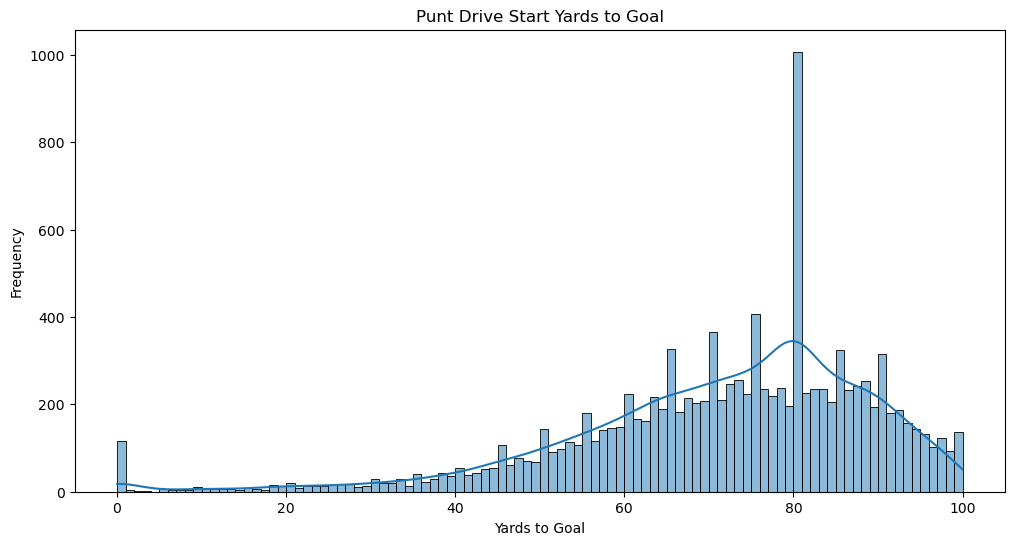

In [106]:
# plot a histogram of punt drive start yards to goal
plt.figure(figsize=(12,6))
sns.histplot(df_punts.punt_drive_start_yards_to_goal, bins=100, kde=True)
plt.title("Punt Drive Start Yards to Goal")
plt.xlabel("Yards to Goal")
plt.ylabel("Frequency")
plt.show()

## 4. Predictive Model

In [107]:
df_punts.head()

,game_id,drive_id,drive_number,season,week,season_type,completed,home_id,home_team,home_conference,home_division,away_id,away_team,away_conference,away_division,offense,offense_conference,defense,defense_conference,scoring,start_period,start_yardline,start_yards_to_goal,end_period,end_yardline,end_yards_to_goal,plays,yards,drive_result,is_home_offense,receiving_team_points_scored,punting_team_points_scored,start_drive_pct_game_played,end_drive_pct_game_played,punt_drive_start_pct_game_played,punt_drive_start_yards_to_goal
0,401525434,4015254344,4,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Navy,American Athletic,Notre Dame,FBS Independents,False,1,75,75,2,58,58,7,17,PUNT,False,0,0,0.232500,0.302222,0.302222,78.0
1,401525434,4015254349,9,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Navy,American Athletic,Notre Dame,FBS Independents,False,3,75,75,3,68,68,3,7,PUNT,False,0,0,0.500000,0.543333,0.543333,63.0
2,401525434,40152543411,11,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Navy,American Athletic,Notre Dame,FBS Independents,False,3,94,94,3,98,98,3,-4,PUNT,False,0,0,0.590000,0.628889,0.628889,37.0
3,401525434,40152543413,13,2023,1,regular,True,87,Notre Dame,FBS Independents,fbs,2426,Navy,American Athletic,fbs,Navy,American Athletic,Notre Dame,FBS Independents,False,3,76,76,3,86,86,7,-10,PUNT,False,0,0,0.680833,0.739722,0.739722,60.0
4,401540199,4015401994,4,2023,1,regular,True,2382,Mercer,Southern,fcs,2453,North Alabama,UAC,fcs,Mercer,Southern,North Alabama,UAC,False,1,22,78,1,16,84,3,-6,PUNT,True,0,0,0.137222,0.166111,0.166111,51.0


In [122]:
n_cores = os.cpu_count()
yardlines = np.arange(101)

# Ensure the yardline values are integers
observed_yardlines = df_punts['punt_drive_start_yards_to_goal'].values.astype(int)

# Create a count array for the observed yardlines
observed_counts = np.bincount(observed_yardlines, minlength=101).astype(int)

with pm.Model() as model:
    # Priors for coefficients that influence the Dirichlet parameters
    beta_intercept = pm.Normal("beta_intercept", mu=0, sigma=1)
    beta_end_yards_to_goal = pm.Normal("beta_end_yards_to_goal", mu=0, sigma=1)
    
    # Function of end_yards_to_goal that influences the Dirichlet parameters
    end_yards_to_goal = pm.Data("end_yards_to_goal", df_punts['end_yards_to_goal'].values)
    alpha = pm.math.exp(beta_intercept + beta_end_yards_to_goal * end_yards_to_goal)
    
    # Dirichlet prior for the multinomial probabilities
    p = pm.Dirichlet("p", a=alpha)
    
    # Likelihood (observations are the counts of yardlines the punts end at)
    pm.Multinomial("y", n=observed_counts.sum(), p=p, observed=observed_counts)
    
    # Perform posterior inference
    trace = pm.sample(
        draws=1000, 
        return_inferencedata=True, 
        cores=n_cores, 
    )

az.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ValueError: Input dimension mismatch: (input[1].shape[0] = 11977, input[5].shape[0] = 101)
Apply node that caused the error: Composite{...}(ExpandDims{axis=0}.0, end_yards_to_goal, ExpandDims{axis=0}.0, LogSoftmax{axis=0}.0, Softmax{axis=0}.0, [-inf -inf ... -inf -inf], [1.160e+02 ... 1.200e+01], [-4.387129 ... 72145e+01])
Toposort index: 26
Inputs types: [TensorType(float64, shape=(1,)), TensorType(int32, shape=(None,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(None,)), TensorType(float64, shape=(None,)), TensorType(float32, shape=(101,)), TensorType(float64, shape=(101,)), TensorType(float64, shape=(101,))]
Inputs shapes: [(1,), (11977,), (1,), (11977,), (11977,), (101,), (101,), (101,)]
Inputs strides: [(8,), (4,), (8,), (8,), (8,), (4,), (8,), (8,)]
Inputs values: [array([0.11572338]), 'not shown', array([-0.27451477]), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown']
Outputs clients: [[Sum{axes=None}(Composite{...}.0)], [All{axes=None}(Composite{...}.1)], [Sum{axes=None}(Composite{...}.2)], [Sum{axes=None}(Composite{...}.3)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [119]:
set(range(0,101)) - set(df_punts['punt_drive_start_yards_to_goal'].unique().tolist())

{4}